In [2]:
import matplotlib.pyplot as plt
from neuralop.datasets import load_darcy_flow_small

In [3]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=100, batch_size=4,
        test_resolutions=[16, 32], n_tests=[50, 50], test_batch_sizes=[4, 2],
        )

train_dataset = train_loader.dataset

Loading test db at resolution 32 with 50 samples and batch-size=2


16


Testing samples for res 16 have shape torch.Size([1, 16, 16])
32
Testing samples for res 32 have shape torch.Size([1, 32, 32])
Training sample have shape torch.Size([16, 16])


/tmp/ipykernel_2811/1079392204.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


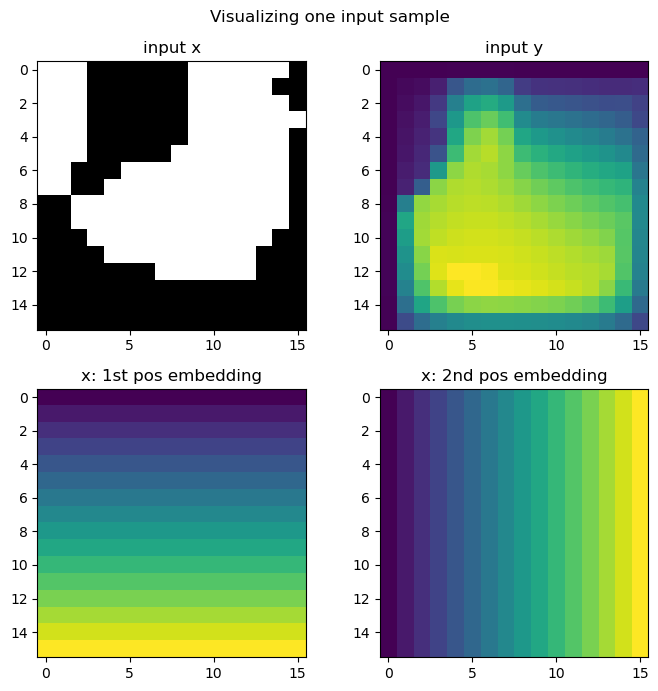

In [4]:
for res, test_loader in test_loaders.items():
    print(res)
    # Get first batch
    batch = next(iter(test_loader))
    x = batch['x']
    y = batch['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')


data = train_dataset[0]
x = data['x']
y = data['y']

print(f'Training sample have shape {x.shape[1:]}')


# Which sample to view
index = 0

data = train_dataset[index]
data = data_processor.preprocess(data, batched=False)
x = data['x']
y = data['y']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
fig.show()

In [5]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0')

In [6]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
        positional_encoding=True
)
data_processor = data_processor.to(device)

Loading test db at resolution 32 with 50 samples and batch-size=32


In [7]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 523257 parameters.


In [8]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [10]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 16, 9), rank=(26, 26, 13, 7))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * T

In [11]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [12]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

{'32_h1': 0.36004722595214844, '32_l2': 0.22335933685302733}

/tmp/ipykernel_2811/460399620.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


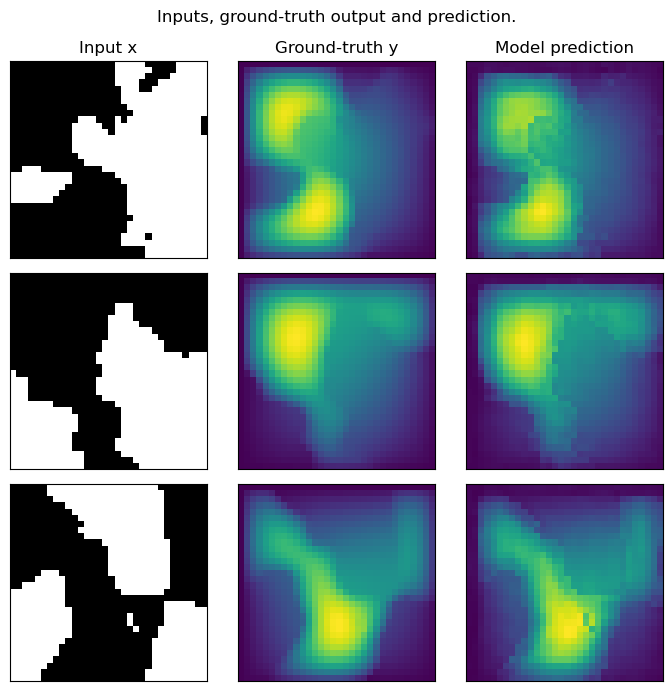

In [13]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu().data.numpy(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().cpu().data.numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().cpu().data.numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()